<a href="https://colab.research.google.com/github/AmeerAliSaleem/machine-learning-algorithms-unpacked/blob/main/Pokemon_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying images of Pokemon in PyTorch
This notebook is best run in Google Colab.
You will need your own Kaggle API key to read in the dataset from the Kaggle website (follow the instructions [here](https://saturncloud.io/blog/how-to-use-kaggle-datasets-in-google-colab/)). Upload your kaggle.json to current directory.

You can use Colab's GPU resources for free: more info [here](https://medium.com/data-science-in-your-pocket/understanding-google-colab-free-gpu-in-detail-15074081d494).

## Imports

In [1]:
import os
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt

!pip install jovian --upgrade --quiet
import jovian

import torch
from torch import optim
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm

import torchvision
from torchvision import datasets, transforms

! pip install torchmetrics
import torchmetrics

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.9 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Sun Nov 23 13:52:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Fix randomness of results
torch.manual_seed(8)

## Reading in the data

In [4]:
# Import data from Kaggle
# Make sure that your kaggle.json has been uploaded to the current directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download lantian773030/pokemonclassification

Dataset URL: https://www.kaggle.com/datasets/lantian773030/pokemonclassification
License(s): copyright-authors
 99% 414M/417M [00:04<00:00, 96.2MB/s]
100% 417M/417M [00:04<00:00, 94.4MB/s]


In [5]:
file = "pokemonclassification.zip"

# Extract contents of zip file to current directory
with ZipFile(file, 'r') as zip:
    zip.printdir()
    print('extraction...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg 2019-11-09 23:16:12        58066
PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg 2019-11-09 23:16:12        14084
PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg 2019-11-09 23:16:12        12171
PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg 2019-11-09 23:16:12        22471
PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg 2019-11-09 23:16:12        22253
PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg 2019-11-09 23:16:12        23846
PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg 2019-11-09 23:16:12        56119
PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg 2019-11-09 23:16:12        51559
PokemonData/Golbat/a45a14a67a7348bba57c06467bb73cde.jpg 2019-11-09 23:16:12        20798
PokemonData/Golbat/acc2b44eada74a25a64c041b2e80c453.jpg 2019-11-09 23:16:12        22378
PokemonData/Golbat/af30483e382240d38890dec39e083b08.jpg 201

In [7]:
# Should have all 150 classes in the folder
len(os.listdir('PokemonData/'))

150

## Data augmentations
We resize all the images to 64x64 to maintain consistency in the sizes of the images for the CNN.

In [8]:
image_size = 64
initial_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

In [9]:
dataset = datasets.ImageFolder('PokemonData/', transform=initial_transforms)

In [10]:
dataset

Dataset ImageFolder
    Number of datapoints: 6820
    Root location: PokemonData/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [11]:
generator = torch.Generator().manual_seed(42)
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, generator=generator)

In [12]:
dataloader.dataset

Dataset ImageFolder
    Number of datapoints: 6820
    Root location: PokemonData/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

NB the DataLoader reads in the class labels in chronological Pokemon name order, not Pokedex order.

In [13]:
pokemon_names = os.listdir('PokemonData/')
pokemon_names = sorted(pokemon_names)

In [14]:
data_iter = iter(dataloader)
images, labels = next(data_iter)

In [15]:
images.shape

torch.Size([1, 3, 64, 64])

We can see what a few of the images look like when scaled down:

Kangaskhan


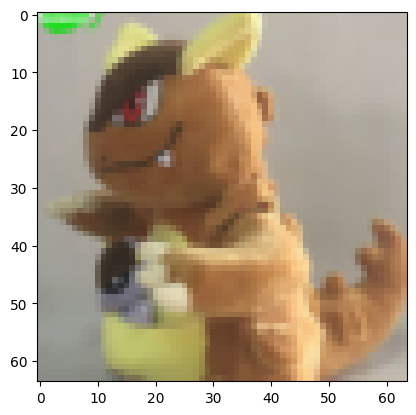

In [16]:
npimg = images[0].numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])

Voltorb


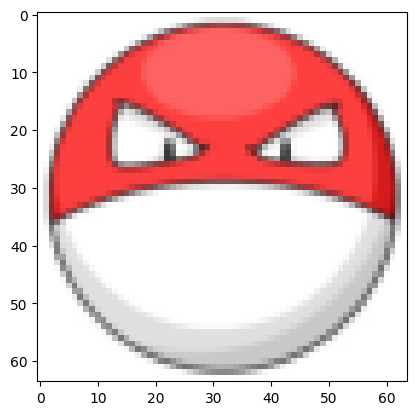

In [17]:
images, labels = next(data_iter)

npimg = images[0].numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])

Dratini


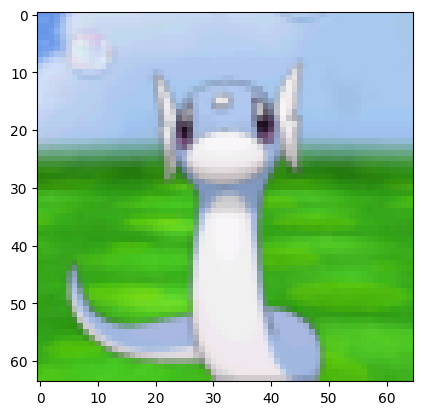

In [18]:
images, labels = next(data_iter)

npimg = images[0].numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])

In [19]:
# Train-test split
train, test = torch.utils.data.random_split(dataloader.dataset, lengths=[0.7,0.3], generator=generator)

In [20]:
train

Before building the model, we apply random transformations to the training data. The goal of this step is to intentionally introduce noise that will prevent the CNN from overfitting.

In [21]:
train.dataset.transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=image_size, scale=(0.8,1)),
    transforms.ToTensor(),
    # transforms.Normalize()
])

Let's see what the transformations lead to:

Pidgeotto


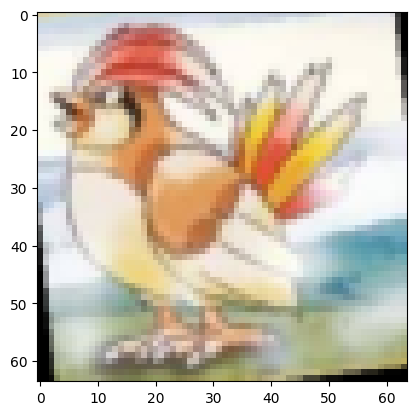

In [22]:
train_iter = iter(train)
images, labels = next(train_iter)

npimg = images.numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])

Ponyta


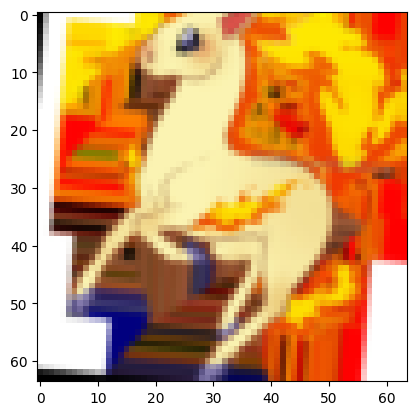

In [23]:
images, labels = next(train_iter)

npimg = images.numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])

Vaporeon


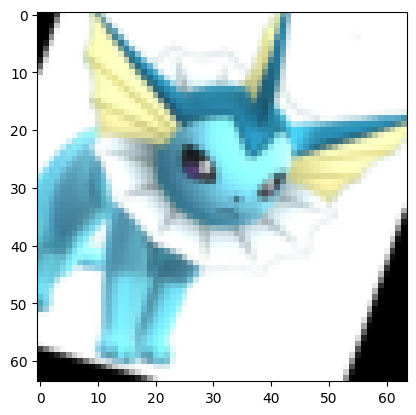

In [24]:
images, labels = next(train_iter)

npimg = images.numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])

# Building the CNN
We follow the architecture implementation of the following PrePrint: https://www.preprints.org/manuscript/202502.1282

In [25]:
class CNN(nn.Module):
  def __init__(self, num_input_channels, num_classes):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels=num_input_channels,
        out_channels=64,
        kernel_size=5,
        padding=2
    )
    self.pool1 = nn.MaxPool2d(
        kernel_size=2
    )
    self.conv2 = nn.Conv2d(
        in_channels=64,
        out_channels=128,
        kernel_size=3,
        padding=1
    )
    self.pool2 = nn.MaxPool2d(
        kernel_size=2
    )
    self.fc = nn.Linear(
        in_features=128*16*16,
        out_features=num_classes
    )

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.reshape(x.shape[0], -1) # Flatten tensor for input to fully connected layer
    x = self.fc(x)

    return x

In [26]:
cnn = CNN(3, len(pokemon_names))
print(cnn)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=32768, out_features=150, bias=True)
)


In [27]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(3, len(pokemon_names)).to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           4,864
         MaxPool2d-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 32, 32]          73,856
         MaxPool2d-4          [-1, 128, 16, 16]               0
            Linear-5                  [-1, 150]       4,915,350
Total params: 4,994,070
Trainable params: 4,994,070
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.75
Params size (MB): 19.05
Estimated Total Size (MB): 22.85
----------------------------------------------------------------


In [28]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [29]:
training_data = torch.utils.data.DataLoader(train.dataset, batch_size=32, shuffle=True)

In [30]:
training_data.dataset

Dataset ImageFolder
    Number of datapoints: 6820
    Root location: PokemonData/
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [31]:
len(training_data)

214

In [32]:
images.shape[0]

3

In [33]:
len(training_data)

214

In [34]:
len(training_data.dataset)

6820

In [35]:
num_epochs = 20

for epoch in range(num_epochs):
  cnn.train()
  total_loss = 0
  for batch_index, (image_data, labels) in enumerate(training_data):
    optimizer.zero_grad()
    pred = cnn(image_data)
    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()
    print(f"Batch loss: {loss.item():.4f}")
    total_loss += loss.item() * image_data.shape[0]

  epoch_loss = total_loss / len(training_data.dataset)
  print(f"Epoch [{epoch+1}/{num_epochs}]] Average loss: {epoch_loss:.4f}")

Batch loss: 5.0271
Batch loss: 6.9014
Batch loss: 5.7556
Batch loss: 5.5660
Batch loss: 5.1167
Batch loss: 5.0755
Batch loss: 5.0321
Batch loss: 5.0145
Batch loss: 5.0109
Batch loss: 5.0095
Batch loss: 5.0089
Batch loss: 5.0111
Batch loss: 5.0107
Batch loss: 5.0112
Batch loss: 5.0094
Batch loss: 5.0097
Batch loss: 5.0096
Batch loss: 5.0003
Batch loss: 4.9882
Batch loss: 5.0095
Batch loss: 4.9976
Batch loss: 4.9989
Batch loss: 4.9942
Batch loss: 5.0115
Batch loss: 4.9365
Batch loss: 4.9344
Batch loss: 4.9624
Batch loss: 4.9588
Batch loss: 4.9868
Batch loss: 4.9743
Batch loss: 4.9882
Batch loss: 4.9279
Batch loss: 4.9084
Batch loss: 4.9151
Batch loss: 4.9154
Batch loss: 4.8718
Batch loss: 4.9850
Batch loss: 4.9041
Batch loss: 4.9299
Batch loss: 4.9069
Batch loss: 4.9709
Batch loss: 4.9060
Batch loss: 4.9637
Batch loss: 4.9136
Batch loss: 4.8838
Batch loss: 4.8279
Batch loss: 4.7206
Batch loss: 4.6862
Batch loss: 5.0486
Batch loss: 4.8948
Batch loss: 4.8628
Batch loss: 4.9397
Batch loss: 

In [36]:
# Save the model (in current directory)
torch.save(cnn.state_dict(), 'cnn_params_20_epochs.pth')

In [247]:
# Load model (make sure cnn_params.pth is in the directory first)
model = CNN(num_input_channels=3, num_classes=len(pokemon_names))
model.load_state_dict(torch.load('cnn_params.pth'))#, weights_only=True)

<All keys matched successfully>

# (Brief) Evaluation
We can now evaluate the model that we trained in the previous section.

In [44]:
def model_output(model, image):
  """
  Returned the Pokemon prediction for the model with the given input image.
  """
  pred = model(image.unsqueeze(0))
  prob = F.softmax(pred, dim=1)
  predicted_class = pred.argmax(dim=1).item()

  return pokemon_names[predicted_class]

Jolteon
Raichu


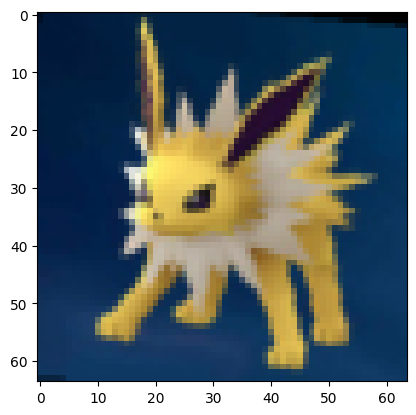

In [45]:
test_iter = iter(test)
images, labels = next(test_iter)

npimg = images.numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])
print(model_output(cnn, images))

Porygon
Porygon


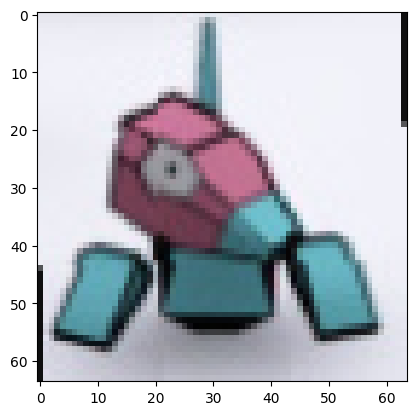

In [48]:
images, labels = next(test_iter)

npimg = images.numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])

print(model_output(cnn, images))

Kangaskhan
Mankey


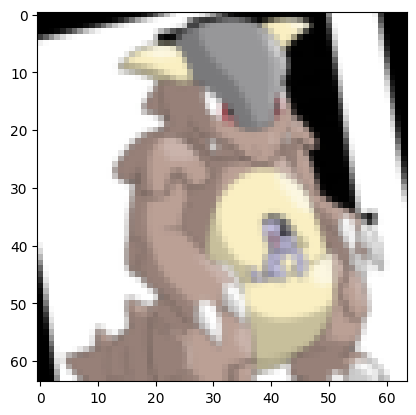

In [49]:
images, labels = next(test_iter)

npimg = images.numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])

print(model_output(cnn, images))

Caterpie
Caterpie


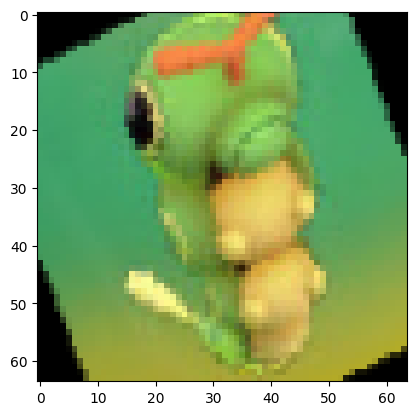

In [50]:
images, labels = next(test_iter)

npimg = images.numpy()

plt.imshow(np.transpose(npimg, (1,2,0)))
print(pokemon_names[labels])

print(model_output(cnn, images))

The model is clearly not perfect. But still very cool to see it making predictins on its own!

# Visualising the learned kernels
This isn't necessarily a visually intuitive thing to do, but I think it's cool to sample some of the kernels learned by the model, and see what sort of features are extracted from the input images.

NB I used Claude to help speed up the formatting and plotting

In [56]:
# Customize colors
plt.rcParams['figure.facecolor'] = '#161718'
plt.rcParams['axes.facecolor'] = '#161718'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['grid.color'] = '#404040'

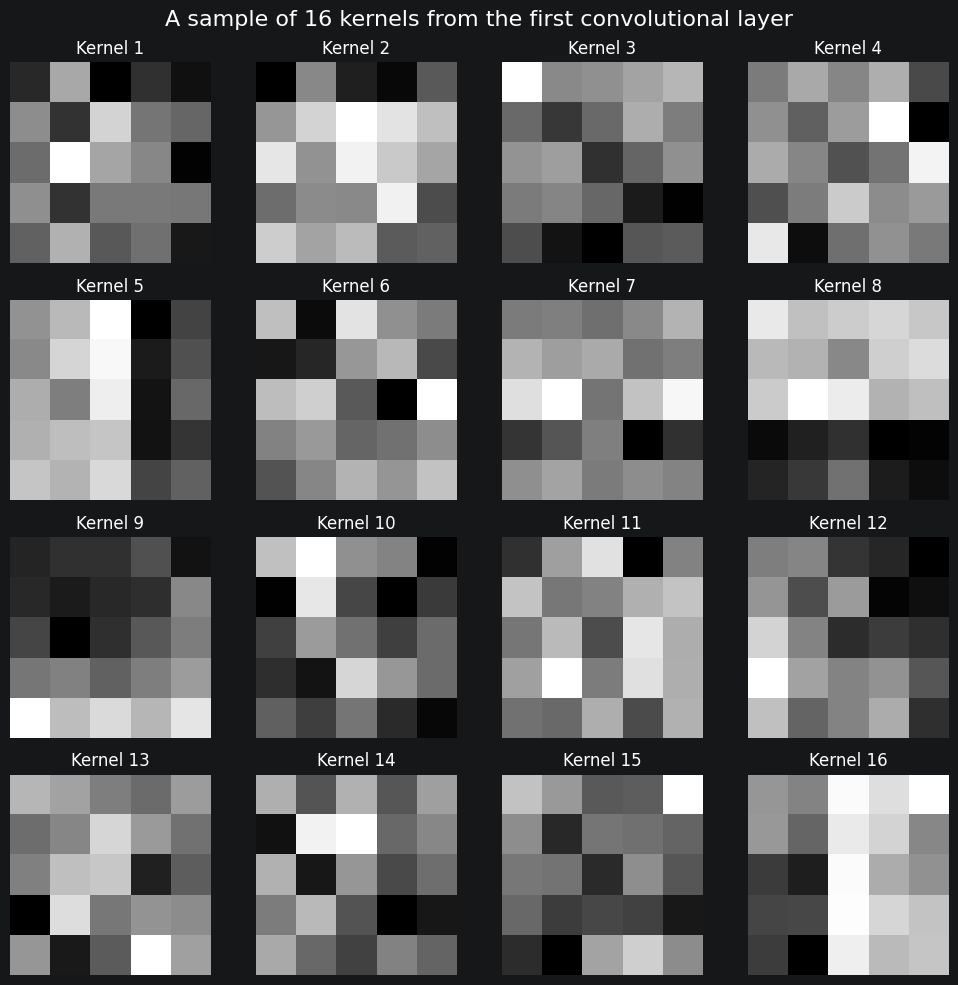

<Figure size 640x480 with 0 Axes>

In [66]:
# Get the first convolutional layer's weights
conv1_weights = cnn.conv1.weight.data.cpu()  # Shape: [64, 3, 5, 5]

# Visualize first 16 kernels from the first input channel
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < conv1_weights.shape[0]:
        # Take the kernel for output channel i, average across input channels
        kernel = conv1_weights[i].mean(dim=0)  # Average of RGB channels
        ax.imshow(kernel, cmap='gray')

        ax.set_title(f'Kernel {i+1}')
        ax.axis('off')
plt.suptitle("A sample of 16 kernels from the first convolutional layer", fontsize=16)
plt.tight_layout()
plt.show()
plt.savefig('16_kernels.png')

In [262]:
# Customize colors
plt.rcParams['figure.facecolor'] = '#161718'
plt.rcParams['axes.facecolor'] = '#161718'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['grid.color'] = '#404040'

In [70]:
test_iter = iter(test)
images, labels = next(test_iter)

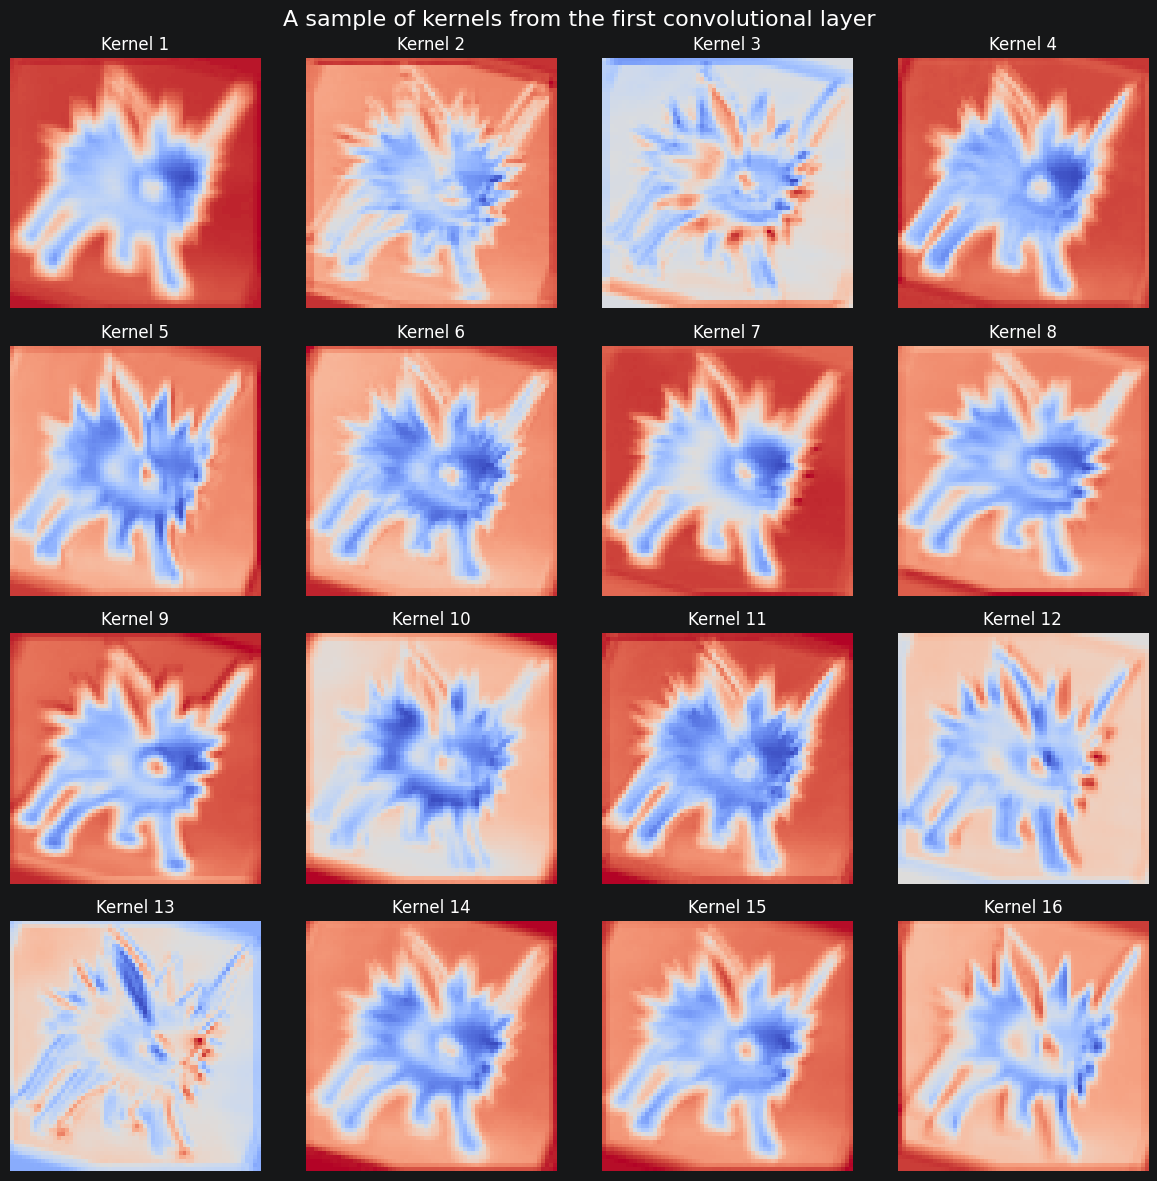

<Figure size 640x480 with 0 Axes>

In [71]:
# Hook to capture intermediate outputs
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
cnn.conv1.register_forward_hook(get_activation('conv1'))
cnn.conv2.register_forward_hook(get_activation('conv2'))

# Forward pass
cnn.eval()
with torch.no_grad():
    output = cnn(images.unsqueeze(0))

# Visualize conv1 feature maps (first 16 of 64)
conv1_features = activations['conv1'].squeeze(0)  # Remove batch dimension

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < 16:
        ax.imshow(conv1_features[i].cpu(), cmap='coolwarm')
        ax.set_title(f'Kernel {i+1}')
        ax.axis('off')
plt.suptitle('A sample of kernels from the first convolutional layer', fontsize=16)
plt.tight_layout()
plt.show()
plt.savefig('16_kernels_colour_maps.png')

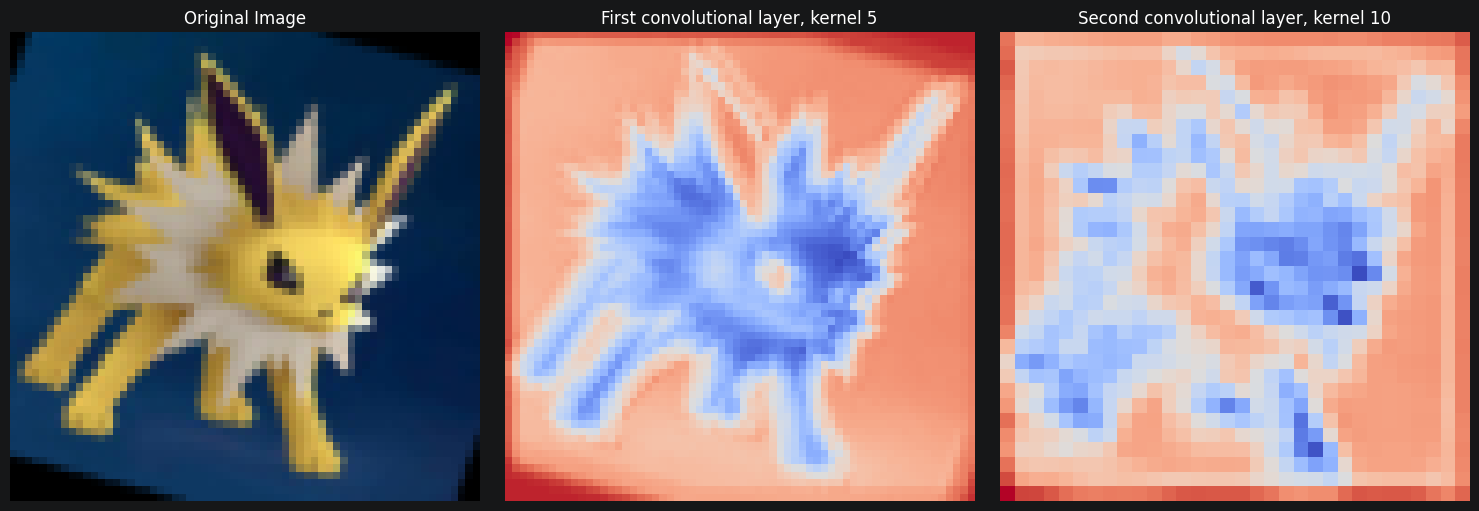

<Figure size 640x480 with 0 Axes>

In [72]:
# Show original image
original_img = images.squeeze(0).permute(1, 2, 0).cpu()  # [H, W, 3]

fig = plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')

# One kernel from conv1
conv1_index = 5
plt.subplot(1, 3, 2)
plt.imshow(conv1_features[conv1_index].cpu(), cmap='coolwarm')
plt.title(f'First convolutional layer, kernel {conv1_index}')
plt.axis('off')

# One kernel from conv2
conv2_index = 10
conv2_features = activations['conv2'].squeeze(0)
plt.subplot(1, 3, 3)
plt.imshow(conv2_features[conv2_index].cpu(), cmap='coolwarm')
plt.title(f'Second convolutional layer, kernel {conv2_index}')
plt.axis('off')

plt.tight_layout()
plt.show()
plt.savefig('kernels_layers.png')